# Pripremni koraci

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('brca_metabric/Final_Data.tsv', sep='\t')

Da bismo mogli da izračunamo korelaciju atributa, moramo dodeliti dummy vrednosti trenutnim vrednostima atributa.

In [3]:
LYMPH_dummy = pd.get_dummies(data['LYMPH_NODES_EXAMINED_POSITIVE'], prefix='LYMPH', drop_first=True)
CELLULARITY_dummy = pd.get_dummies(data['CELLULARITY'], prefix='CELLULARITY', drop_first=True)
ER_dummy = pd.get_dummies(data['ER_IHC'], prefix='ER_IHC', drop_first=True)
HER2SNP_dummy = pd.get_dummies(data['HER2_SNP6'], prefix='HER2_SNP6', drop_first=True)
HER_dummy = pd.get_dummies(data['HER2_STATUS'], prefix='HER2_STATUS', drop_first=True)
PR_dummy = pd.get_dummies(data['PR_STATUS'], prefix='PR_STATUS', drop_first=True)
INTCLUS_dummy = pd.get_dummies(data['INTCLUST'], prefix='INTCLUST', drop_first=True)
GRADE_dummy = pd.get_dummies(data['GRADE'], prefix='GRADE', drop_first=True)

In [4]:
df = pd.concat([data['LYMPH_NODES_EXAMINED_POSITIVE'], data['NPI'], CELLULARITY_dummy, ER_dummy, HER2SNP_dummy, HER_dummy,
                PR_dummy, INTCLUS_dummy, GRADE_dummy], axis = 1)
y = y = data[['CLAUDIN_SUBTYPE']]

In [5]:
df.head()

,LYMPH_NODES_EXAMINED_POSITIVE,NPI,CELLULARITY_Low,CELLULARITY_Moderate,ER_IHC_Positve,HER2_SNP6_LOSS,HER2_SNP6_NEUTRAL,HER2_SNP6_UNDEF,HER2_STATUS_Positive,PR_STATUS_Positive,...,INTCLUST_3,INTCLUST_4ER+,INTCLUST_4ER-,INTCLUST_5,INTCLUST_6,INTCLUST_7,INTCLUST_8,INTCLUST_9,GRADE_2,GRADE_3
0,10,6.044,0,1,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,0,4.020,0,0,1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,1
2,1,4.030,0,0,1,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
3,3,4.050,0,1,1,0,1,0,0,1,...,0,0,0,0,0,0,0,1,1,0
4,8,6.080,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,1,0,1


In [6]:
df.shape

(1974, 22)

## Korelacija

Sada ćemo da pokušamo da ustanovimo korelacije između atributa i tako smanjimo broj atributa za modelovanje.

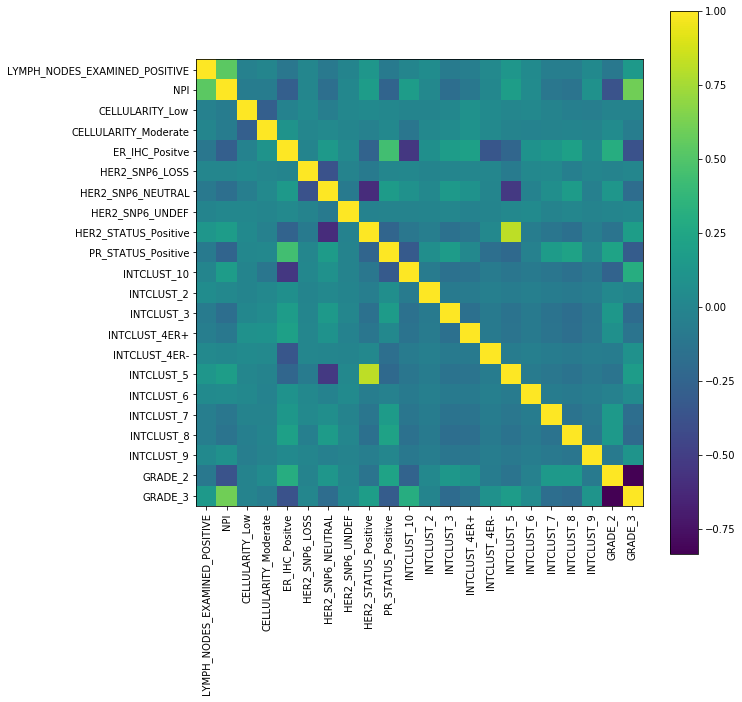

In [7]:
corr_matrix = df.corr()

plt.figure(figsize=(10,10))

data_hm = pd.DataFrame(df)
plt.xticks(np.arange(22), list(df.columns), rotation='vertical')
plt.yticks(np.arange(22), list(df.columns))
corr = data_hm.corr()
plt.imshow(corr)
plt.colorbar()
plt.show()

Sa ovog grafika se vidi da LYMPH_NODES_ECAMINED_POSITIVE i NPI, INTCLUS_5 i HER2_Status_positive imaju visok stepen korelacije, kao i GRADE_2 i GRADE_3. Pošto nismo sigurni koji će skup atributa dati najbolju predikciju, u svakom modelu probaćemo drugačiji set atributa, i na osnovu toga dati ocenu.

# Modeli

## Random forest

Vrednosti ciljnih atributa ćemo učiniti binarnim i zatim ćemo pokušati predikciju sa različitm setovima atributa.

### Odvajanje trening i test skupa

In [8]:
from sklearn import model_selection 

Intel(R) Data Analytics Acceleration Library (Intel(R) DAAL) solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


In [9]:
xtrain, xtest, ytrain, ytest = model_selection.train_test_split(df, y, test_size=0.1, random_state=1, shuffle=True, stratify=y)

### Skaliranje

In [10]:
from sklearn.preprocessing import StandardScaler

In [11]:
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_sc = scaler.transform(xtrain)
xtest_sc = scaler.transform(xtest)

/home/naca/anaconda3/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/naca/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/naca/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


### Modelovanje

Kako bismo kasnije mogli da znamo koji je model doneo najbolju ocenu, čuvaćemo F-mere u jednom nizu i kasnije ćemo ih prikazati na grafiku.

In [12]:
fscores = []
fscore_models = [] # za imena

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.metrics import classification_report

In [14]:
rf_classifier = OutputCodeClassifier(
    estimator=RandomForestClassifier(random_state=0 ),
      random_state=0, code_size=15).fit(xtrain, ytrain)
rf_classifier.fit(xtrain, ytrain)
rf_predictions = rf_classifier.predict(xtest)
print(classification_report(ytest, rf_predictions))

/home/naca/anaconda3/lib/python2.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/naca/anaconda3/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

       Basal       0.43      0.43      0.43        21
        Her2       0.61      0.50      0.55        22
        LumA       0.61      0.74      0.67        70
        LumB       0.53      0.50      0.52        48
      Normal       0.29      0.13      0.18        15
 claudin-low       0.32      0.32      0.32        22

   micro avg       0.53      0.53      0.53       198
   macro avg       0.46      0.44      0.44       198
weighted avg       0.52      0.53      0.52       198



In [15]:
from sklearn.metrics import f1_score
fscores.append(f1_score(ytest, rf_predictions, average='weighted'))
fscore_models.append("forest_all")

Kako je zastupljenost klasa Normal i claudin-low manja u odnosu na ostale, probaćemo da svakoj klasi dodamo težine:

In [16]:
from sklearn.utils import class_weight

target = 'CLAUDIN_SUBTYPE'
class_weights = list(class_weight.compute_class_weight('balanced', np.unique(ytrain), ytrain[target]))
classes = list(np.unique(ytrain))
class_dict = {
        classes[0] : class_weights[0],
        classes[1] : class_weights[1],
        classes[2] : class_weights[2],
        classes[3] : class_weights[3],
        classes[4] : class_weights[4],
        classes[5] : class_weights[5]
}
    

In [17]:
rf_classifier = RandomForestClassifier(random_state=0, class_weight=class_dict)
rf_classifier.fit(xtrain, ytrain)
rf_predictions = rf_classifier.predict(xtest)
print(classification_report(ytest, rf_predictions))

              precision    recall  f1-score   support

       Basal       0.53      0.43      0.47        21
        Her2       0.50      0.55      0.52        22
        LumA       0.60      0.71      0.65        70
        LumB       0.47      0.35      0.40        48
      Normal       0.20      0.20      0.20        15
 claudin-low       0.23      0.23      0.23        22

   micro avg       0.48      0.48      0.48       198
   macro avg       0.42      0.41      0.41       198
weighted avg       0.48      0.48      0.48       198



/home/naca/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [18]:
fscores.append(f1_score(ytest, rf_predictions, average='weighted'))
fscore_models.append("forest_all_weighetd")

Hajde da vidimo možemo li bolje sa drugačijim setom atributa.

#### Poređenje rezultata modela sa različitim atributima - 1

In [19]:
df = pd.concat([data['LYMPH_NODES_EXAMINED_POSITIVE'], CELLULARITY_dummy, ER_dummy, HER2SNP_dummy, HER_dummy,
                PR_dummy, INTCLUS_dummy, GRADE_dummy], axis = 1)
y = data[['CLAUDIN_SUBTYPE']]

xtrain, xtest, ytrain, ytest = model_selection.train_test_split(df, y, test_size=0.1, random_state=1, shuffle=True, stratify=y)
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_sc = scaler.transform(xtrain)
xtest_sc = scaler.transform(xtest)
                                                               
rf_classifier = OutputCodeClassifier(
    estimator=RandomForestClassifier(random_state=0),
      random_state=0, code_size=15).fit(xtrain, ytrain)
rf_classifier.fit(xtrain, ytrain)
rf_predictions = rf_classifier.predict(xtest)

print(classification_report(ytest, rf_predictions))

/home/naca/anaconda3/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/naca/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  
/home/naca/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


              precision    recall  f1-score   support

       Basal       0.59      0.62      0.60        21
        Her2       0.61      0.64      0.62        22
        LumA       0.64      0.74      0.69        70
        LumB       0.60      0.54      0.57        48
      Normal       0.25      0.20      0.22        15
 claudin-low       0.29      0.23      0.26        22

   micro avg       0.57      0.57      0.57       198
   macro avg       0.50      0.49      0.49       198
weighted avg       0.56      0.57      0.56       198



In [20]:
fscores.append(f1_score(ytest, rf_predictions, average='weighted'))
fscore_models.append("forest_fst_subset")

In [21]:
df = pd.concat([data['LYMPH_NODES_EXAMINED_POSITIVE'], CELLULARITY_dummy, ER_dummy, HER2SNP_dummy, HER_dummy,
                PR_dummy, INTCLUS_dummy], axis = 1)
y = data[['CLAUDIN_SUBTYPE']]

xtrain, xtest, ytrain, ytest = model_selection.train_test_split(df, y, test_size=0.1, random_state=1, shuffle=True, stratify=y)
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_sc = scaler.transform(xtrain)
xtest_sc = scaler.transform(xtrain)
                                                               
rf_classifier = OutputCodeClassifier(
    estimator=RandomForestClassifier(random_state=0),
      random_state=0, code_size=15).fit(xtrain, ytrain)
rf_classifier.fit(xtrain, ytrain)
rf_predictions = rf_classifier.predict(xtest)

print(classification_report(ytest, rf_predictions))

/home/naca/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  
/home/naca/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


              precision    recall  f1-score   support

       Basal       0.62      0.62      0.62        21
        Her2       0.58      0.64      0.61        22
        LumA       0.62      0.76      0.68        70
        LumB       0.55      0.46      0.50        48
      Normal       0.20      0.07      0.10        15
 claudin-low       0.35      0.36      0.36        22

   micro avg       0.56      0.56      0.56       198
   macro avg       0.49      0.48      0.48       198
weighted avg       0.54      0.56      0.54       198



In [22]:
fscores.append(f1_score(ytest, rf_predictions, average='weighted'))
fscore_models.append("forest_3rd_subset")

In [23]:
df = pd.concat([ER_dummy,  GRADE_dummy, HER2SNP_dummy,
                PR_dummy, INTCLUS_dummy], axis = 1)
y = data[['CLAUDIN_SUBTYPE']]

xtrain, xtest, ytrain, ytest = model_selection.train_test_split(df, y, test_size=0.1, random_state=1, shuffle=True, stratify=y)
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_sc = scaler.transform(xtrain)
xtest_sc = scaler.transform(xtest)
                                                               
rf_classifier = OutputCodeClassifier(
    estimator=RandomForestClassifier(random_state=0),
      random_state=0, code_size=15).fit(xtrain, ytrain)
rf_classifier.fit(xtrain, ytrain)
rf_predictions = rf_classifier.predict(xtest)

print(classification_report(ytest, rf_predictions))

/home/naca/anaconda3/lib/python2.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/naca/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  
/home/naca/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


              precision    recall  f1-score   support

       Basal       0.74      0.67      0.70        21
        Her2       0.67      0.55      0.60        22
        LumA       0.58      0.83      0.68        70
        LumB       0.60      0.44      0.51        48
      Normal       0.20      0.07      0.10        15
 claudin-low       0.38      0.36      0.37        22

   micro avg       0.58      0.58      0.58       198
   macro avg       0.53      0.48      0.49       198
weighted avg       0.56      0.58      0.55       198



In [24]:
fscores.append(f1_score(ytest, rf_predictions, average='weighted'))
fscore_models.append("forest_5th_subset")

In [40]:
# plt.figure(figsize=(12, 3))
# plt.bar(fscore_models, fscores)

## Linear SVC

In [26]:
from sklearn.svm import LinearSVC

In [27]:
fscores_svc = []
fscores_models_svc = []

In [28]:
df = pd.concat([data['LYMPH_NODES_EXAMINED_POSITIVE'], data['NPI'], CELLULARITY_dummy, ER_dummy, 
                HER2SNP_dummy, HER_dummy,
                PR_dummy, GRADE_dummy], axis = 1)
y = data[['CLAUDIN_SUBTYPE']]

xtrain, xtest, ytrain, ytest = model_selection.train_test_split(df, y, test_size=0.1, random_state=1, shuffle=True, stratify=y)
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_sc = scaler.transform(xtrain)
xtest_sc = scaler.transform(xtest)
                                                               
clf = OutputCodeClassifier(
    estimator=LinearSVC(random_state=0, multi_class='ovr'),
      random_state=0, code_size=15).fit(xtrain_sc, ytrain)

clf_predicions = clf.predict(xtest_sc)

print(classification_report(ytest, clf_predicions))

/home/naca/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
/home/naca/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.
/home/naca/anaconda3/lib/python2.7/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


              precision    recall  f1-score   support

       Basal       0.50      0.71      0.59        21
        Her2       0.58      0.68      0.62        22
        LumA       0.57      0.81      0.67        70
        LumB       0.41      0.33      0.37        48
      Normal       1.00      0.07      0.12        15
 claudin-low       0.00      0.00      0.00        22

   micro avg       0.53      0.53      0.53       198
   macro avg       0.51      0.44      0.40       198
weighted avg       0.49      0.53      0.47       198



In [29]:
fscores_svc.append(f1_score(ytest, clf_predicions, average='weighted'))
fscores_models_svc.append("all")
fscores.append(f1_score(ytest, clf_predicions, average='weighted'))
fscore_models.append("svc_all")

In [39]:
df = pd.concat([data['LYMPH_NODES_EXAMINED_POSITIVE'], CELLULARITY_dummy, ER_dummy, HER2SNP_dummy, HER_dummy,
                PR_dummy, INTCLUS_dummy, GRADE_dummy], axis = 1)
y = data[['CLAUDIN_SUBTYPE']]

xtrain, xtest, ytrain, ytest = model_selection.train_test_split(df, y, test_size=0.1, random_state=1, shuffle=True, stratify=y)
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_sc = scaler.transform(xtrain)
xtest_sc = scaler.transform(xtest)
                                                               
clf = OutputCodeClassifier(
    estimator=LinearSVC(random_state=0, multi_class='ovr'),
      random_state=0, code_size=15).fit(xtrain_sc, ytrain)

clf_predicions = clf.predict(xtest_sc)
print(classification_report(ytest, clf_predicions))

/home/naca/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  
/home/naca/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


              precision    recall  f1-score   support

       Basal       0.70      0.76      0.73        21
        Her2       0.64      0.64      0.64        22
        LumA       0.60      0.91      0.73        70
        LumB       0.69      0.42      0.52        48
      Normal       0.00      0.00      0.00        15
 claudin-low       0.50      0.41      0.45        22

   micro avg       0.62      0.62      0.62       198
   macro avg       0.52      0.52      0.51       198
weighted avg       0.58      0.62      0.58       198



In [31]:
fscores_svc.append(f1_score(ytest, clf_predicions, average='weighted'))
fscores_models_svc.append("fst_subset")
fscores.append(f1_score(ytest, clf_predicions, average='weighted'))
fscore_models.append("svc_fst_subset")

/home/naca/anaconda3/lib/python2.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [32]:
df = pd.concat([ER_dummy,  GRADE_dummy, HER2SNP_dummy,
                PR_dummy, INTCLUS_dummy], axis = 1)
y = data[['CLAUDIN_SUBTYPE']]

xtrain, xtest, ytrain, ytest = model_selection.train_test_split(df, y, test_size=0.1, random_state=1, shuffle=True, stratify=y)
scaler = StandardScaler()
scaler.fit(xtrain)
xtrain_sc = scaler.transform(xtrain)
xtest_sc = scaler.transform(xtest)
                                                               
clf = OutputCodeClassifier(
    estimator=LinearSVC(random_state=0, multi_class='ovr'),
      random_state=0, code_size=15).fit(xtrain_sc, ytrain)

clf_predicions = clf.predict(xtest_sc)
print(classification_report(ytest, clf_predicions))

/home/naca/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  
/home/naca/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype uint8 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


              precision    recall  f1-score   support

       Basal       0.71      0.81      0.76        21
        Her2       0.72      0.59      0.65        22
        LumA       0.58      0.87      0.70        70
        LumB       0.61      0.42      0.49        48
      Normal       0.00      0.00      0.00        15
 claudin-low       0.50      0.41      0.45        22

   micro avg       0.61      0.61      0.61       198
   macro avg       0.52      0.52      0.51       198
weighted avg       0.56      0.61      0.57       198



In [33]:
fscores_svc.append(f1_score(ytest, clf_predicions, average='weighted'))
fscores_models_svc.append("scnd_subset")
fscores.append(f1_score(ytest, clf_predicions, average='weighted'))
fscore_models.append("svc_scnd_subset")

<BarContainer object of 8 artists>

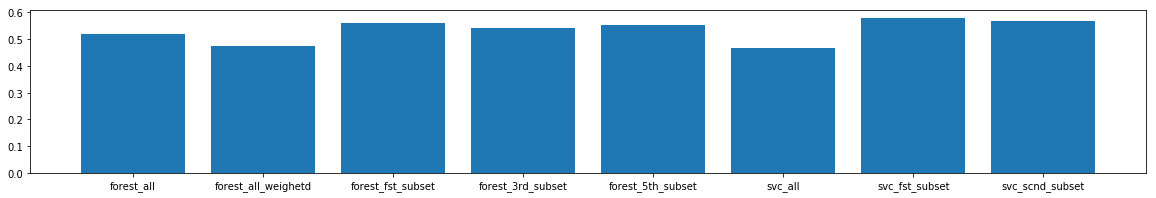

In [35]:
plt.figure(figsize=(20, 3))
plt.bar(fscore_models, fscores)